# Train a shallow SNN on the Randman Dataset

In [130]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DelayGroup, DelayLIF
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

import scipy.signal as signal

## Generate Dataset

Specify the Dataset Parameters

In [131]:
torch.manual_seed(12)
np.random.seed(12)


nb_inputs = 1
nb_time_steps = 200
nb_spikes = 1
nb_outputs = 1
dt = 2e-3

duration = nb_time_steps * dt

In [132]:
inp = torch.tensor([10, 40, 45, 60,70, 100])
data = [(inp, torch.zeros_like(inp))] * 10
labels = [(inp+30, torch.zeros_like(inp))] * 10
# labels = [(torch.tensor([]), torch.tensor([]))]*10


In [133]:
ds_kwargs = dict(
    nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0, target_units=nb_outputs
)

# Split into train, test and validation set
datasets = [
    stork.datasets.RasRasDataset(ds, **ds_kwargs)
    for ds in stork.datasets.split_dataset(
        data, labels, splits=[0.1, 0.1, 0.8], shuffle=False
    )
]
ds_train, ds_valid, ds_test = datasets

print(len(ds_train), len(ds_valid), len(ds_test))

1 1 8


In [134]:
tau_mem = 20e-3
tau_syn = 10e-3

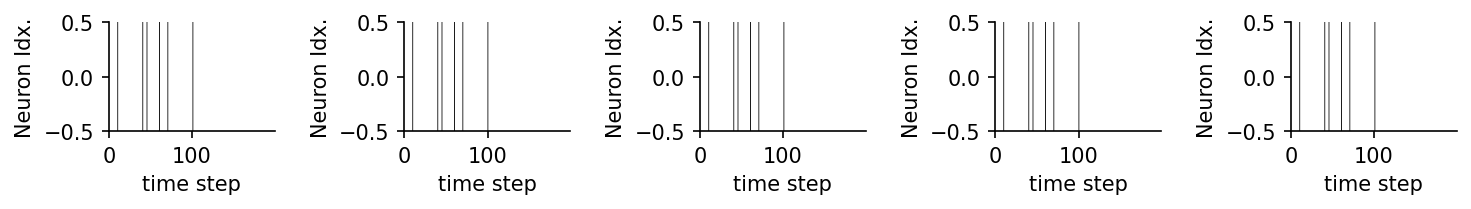

In [135]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_test[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    # ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [136]:
# Model Parameters
batch_size = 1
beta = 20
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 1

lr = 1
nb_epochs = 50

In [137]:
act_fn = stork.activations.CustomSpike

act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [138]:
input_group = model.add_group(InputGroup(nb_inputs))
delay_neurons = model.add_group(
    DelayLIF(
        nb_hidden_units,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn,
        max_delay_timesteps=nb_time_steps // 2,
    )
)

Add synapses between the neuron groups

In [139]:
con = model.add_connection(Connection(input_group, delay_neurons))

In [160]:
con.op.weight = torch.nn.Parameter(torch.tensor([[3.0]]))
print(con.op.weight)

Parameter containing:
tensor([[3.]], requires_grad=True)


In [161]:
for g in model.groups:
    print(g.name)
    if "Delay" in g.name:
        g.delays = torch.nn.Parameter(torch.tensor([10.0001]))

Input
DelayLIFGroup


Add monitors for spikes and membrane potential

In [162]:
for g in model.groups:
    print(g.name)

Input
DelayLIFGroup


In [163]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "mem"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "mem_buffer"))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "spk_buffer"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

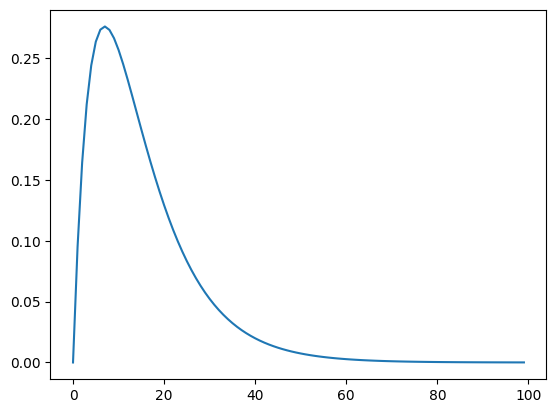

In [164]:
lif_kernel = torch.tensor(stork.utils.get_lif_kernel(tau_mem, tau_syn, dt), dtype=dtype)
# lif_kernel = lif_kernel.flip(0)
plt.plot(lif_kernel)
loss_stack = stork.loss_stacks.vRD_MeanSquareError(kernel=lif_kernel)

We select the SMORMS3 optimizer

In [165]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [166]:
model.configure(
    input=input_group,
    output=delay_neurons,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes

In [167]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq_init"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [7.5]}


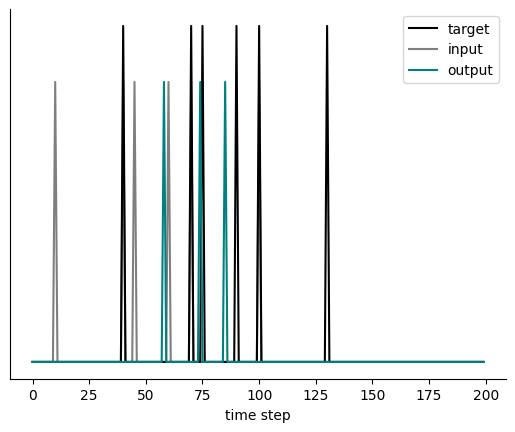

In [168]:
pred = model.predict(ds_train)
plt.plot(ds_train[0][1] * 1.2, color="k", label="target")
plt.plot(ds_train[0][0], color="k", alpha=0.5, label="input")
plt.plot(pred[0], color="teal", label="output")
plt.legend()
plt.xlabel("time step")
plt.yticks([])
sns.despine()

## Training

takes around 13-20 minutes

In [169]:
for name, param in model.named_parameters():
    print(name, end="")
    if "weight" in name:
        # do not require grad
        param.requires_grad = False
        print(param.requires_grad, ": no grad")
    else:
        print()

group2.delays
con1.op.weightFalse : no grad


In [170]:
print(delay_neurons.delays)

Parameter containing:
tensor([10.0001], requires_grad=True)


0: 00  loss=0.0226 reg_loss=0 -- val_loss=0.0219 val_reg_loss=0 t_iter=0.40
1: 00  loss=0.0219 reg_loss=0 -- val_loss=0.0213 val_reg_loss=0 t_iter=0.39
2: 00  loss=0.0213 reg_loss=0 -- val_loss=0.0213 val_reg_loss=0 t_iter=0.41
3: 00  loss=0.0213 reg_loss=0 -- val_loss=0.0207 val_reg_loss=0 t_iter=0.44
4: 00  loss=0.0207 reg_loss=0 -- val_loss=0.0201 val_reg_loss=0 t_iter=0.44
5: 00  loss=0.0201 reg_loss=0 -- val_loss=0.0195 val_reg_loss=0 t_iter=0.39
6: 00  loss=0.0195 reg_loss=0 -- val_loss=0.019 val_reg_loss=0 t_iter=0.37
7: 00  loss=0.019 reg_loss=0 -- val_loss=0.0185 val_reg_loss=0 t_iter=0.40
8: 00  loss=0.0185 reg_loss=0 -- val_loss=0.018 val_reg_loss=0 t_iter=0.38
9: 00  loss=0.018 reg_loss=0 -- val_loss=0.0174 val_reg_loss=0 t_iter=0.41
10: 00  loss=0.0174 reg_loss=0 -- val_loss=0.0168 val_reg_loss=0 t_iter=0.36
11: 00  loss=0.0168 reg_loss=0 -- val_loss=0.0162 val_reg_loss=0 t_iter=0.42
12: 00  loss=0.0162 reg_loss=0 -- val_loss=0.0157 val_reg_loss=0 t_iter=0.39
13: 00  loss=

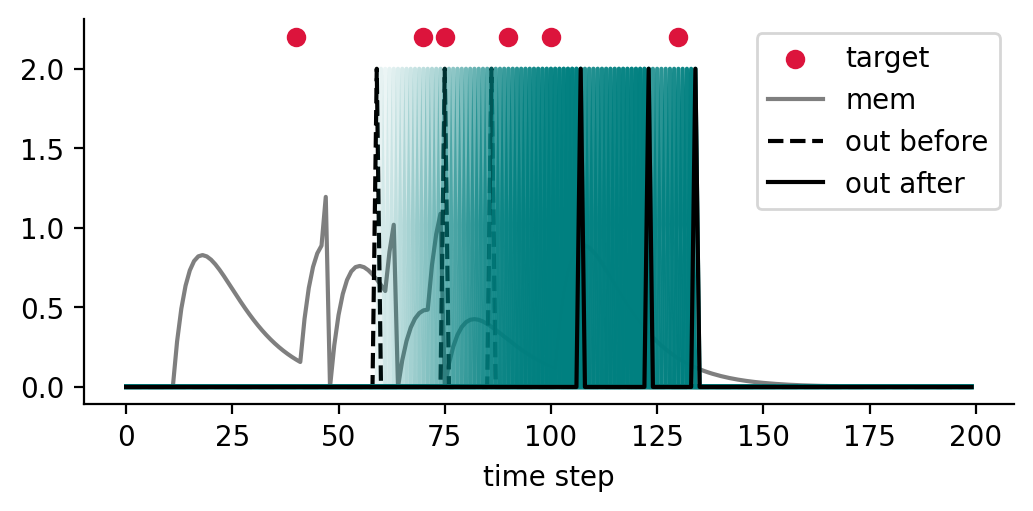

In [171]:
plt.figure(figsize=(6, 2.5), dpi=200)
for e in range(nb_epochs):
    print(e, end=": ")
    history = model.fit_validate(ds_train, ds_valid, nb_epochs=1, verbose=True)

    res = model.monitor(ds_train)

    if e == 0:
        plt.scatter(
            [np.argwhere(ds_train[0][1])[0]], [2.2]*len(np.argwhere(ds_train[0][1])[0]), color="crimson", label="target"
        )
        plt.plot(res[1].squeeze(), alpha=0.5, color="black", label="mem")
        plt.plot(
            delay_neurons.get_flattened_out_sequence().detach().squeeze() * 2,
            "--",
            color="black",
            label="out before",
        )
    plt.plot(
        delay_neurons.get_flattened_out_sequence().detach().squeeze() * 2,
        color="teal",
        alpha=(e + 1) / nb_epochs,
    )

    for key, val in history.items():
        if key in results:
            results[key] += val.tolist()
        else:
            results[key] = val.tolist()

plt.plot(
    delay_neurons.get_flattened_out_sequence().detach().squeeze() * 2,
    color="black",
    alpha=(e + 1) / nb_epochs,
    label="out after",
)
plt.xlabel("time step")
plt.legend()
sns.despine()

In [172]:
print(delay_neurons.delays)

Parameter containing:
tensor([58.6946], requires_grad=True)


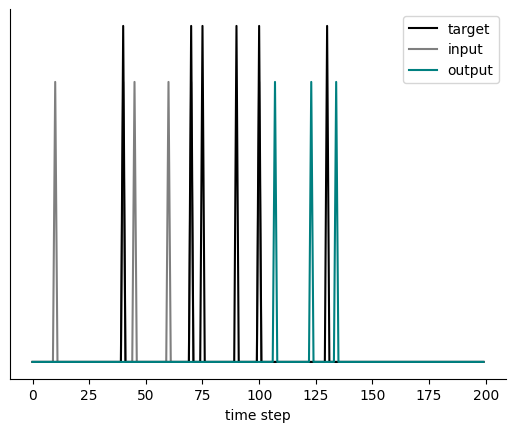

In [173]:
pred = model.predict(ds_train)
plt.plot(ds_train[0][1] * 1.2, color="k", label="target")
plt.plot(ds_train[0][0], color="k", alpha=0.5, label="input")
plt.plot(pred[0], color="teal", label="output")
plt.legend()
plt.xlabel("time step")
plt.yticks([])
sns.despine()

In [174]:
for g in model.groups:
    try:
        print(g.name, g.delays.grad)
    except:
        print(g.name)

Input
DelayLIFGroup tensor([-0.1996])


In [175]:
print(delay_neurons.delays)

Parameter containing:
tensor([58.6946], requires_grad=True)


#### Monitor the model again after training

In [176]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

## Test

In [177]:
scores = model.evaluate(ds_test).tolist()
print(scores)

[0.04874366149306297, 0.0]


In [178]:
l, a = scores
if "test_loss" in results:
    results["test_loss"].append(l)
    results["test_acc"].append(a)
else:
    results["test_loss"] = [l]
    results["test_acc"] = [a]

Test loss:  0.04874366149306297
Test acc.:  0.0 %


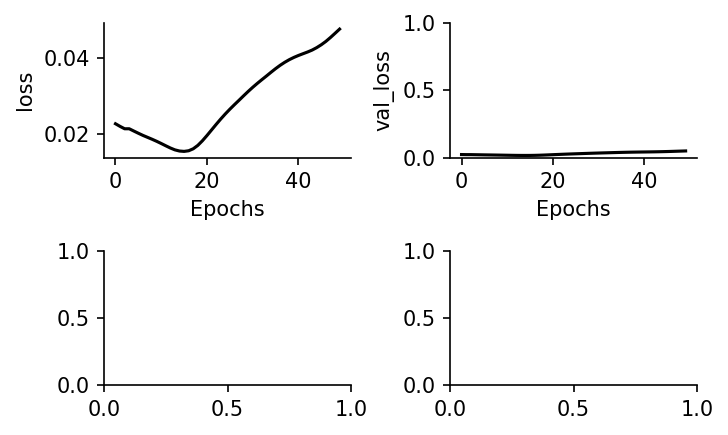

In [179]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(
    [
        "loss",
        "val_loss",
    ]
):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"][-1])
print("Test acc.: ", round(results["test_acc"][-1] * 100, 2), "%")